# Hpol deconvolution + attempt at polarization reco

### Sep 10, 2020

## Code

In [80]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util

In [2]:
# mpl.use('agg') 
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
# mpl.rcParams['mathtext.rm'] = 'Times New Roman'
# mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
# mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# mpl.rc('font', family='serif', size=12)
# mpl.rcParams['xtick.labelsize'] = 16
# mpl.rcParams['ytick.labelsize'] = 16
# mpl.rcParams['xtick.major.size'] = 5
# mpl.rcParams['ytick.major.size'] = 5

# mpl.rcParams['axes.titlesize'] = 20
# mpl.rcParams['axes.labelsize'] = 15
# # mpl.rc('font', size=16)
# mpl.rc('axes', titlesize=20)

# current_palette = sns.color_palette('colorblind', 10)

## Define function

## Antenna deconvolution

In [182]:
def deConvolve_antenna(time, voltage, theta, phi, pol_ant):
    import scipy.signal as signal
    if(pol_ant == 0):
        ant = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
        polarization=np.array([0,0,1])
    if(pol_ant == 1):
        ant = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
        polarization=[0,1,0]
    sampRate = len(time)/(max(time)-min(time))
    b,a = signal.bessel(4, [0.15,0.4], 'bandpass', analog=False, fs=sampRate)
    fft_v, fft_f, dT = util.doFFT(time,voltage)
    response_filter = np.array(util.interpolate_filter(fft_f*1E6))
    dir_res = ant.antenna.directional_response(theta=theta, phi=phi, polarization=polarization)(fft_f*1E6)
    heff = ant.antenna.frequency_response(fft_f*1E6)
    response_antenna = dir_res*heff
    response = response_antenna
    deDis_wf = np.divide(fft_v,abs(response))
    response = np.divide(response,abs(response))
    deDis_wf = np.divide(deDis_wf,response)
    deDis_wf = np.nan_to_num(deDis_wf)
    revert = util.doInvFFT(deDis_wf)
    deDis_wf = signal.lfilter(b, a, revert)
    return time, deDis_wf
    #vetted!
    

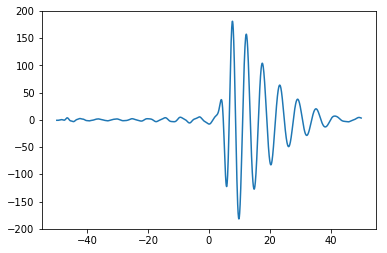

In [185]:
phi = np.deg2rad(90)
theta = np.deg2rad(90)
from scipy import signal

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
sig = antV.apply_response(sig, direction=np.array([-0.88554539,0.37642108,0.2722435]), polarization=np.array([0.25054756,-0.1065009,0.96222839]), force_real=True)
output = antV.front_end(sig)

time = output.times*1E9 #in ns
voltage = output.values*1E3 #in mV
plt.plot(time,voltage)

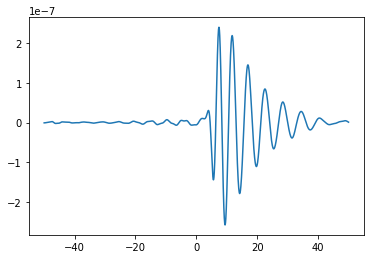

In [186]:
sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
sigH = antH.apply_response(sigH, direction=np.array([-0.88554539,0.37642108,0.2722435]), polarization=np.array([0.25054756,-0.1065009,0.96222839]), force_real=True)
outputH = antH.front_end(sigH)
timeH = outputH.times*1E9 #in ns
voltageH = outputH.values*1E3 #in mV

plt.plot(timeH,voltageH)

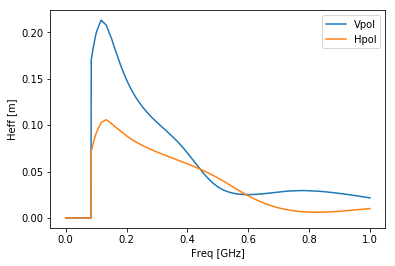

In [170]:
freq = np.linspace(0,1,1000)
resp = antV.antenna.frequency_response(freq*1E9)*antV.antenna.directional_response(theta=np.pi/2, phi=0, polarization=[0,0,1])(freq*1E9)
resp2 = antH.antenna.frequency_response(freq*1E9)*antH.antenna.directional_response(theta=np.pi/2, phi=0, polarization=[0,1,0])(freq*1E9)
plt.plot(freq,abs(resp), label="Vpol")
plt.plot(freq,abs(resp2), label="Hpol")
plt.xlabel("Freq [GHz]")
plt.ylabel("Heff [m]")
# plt.xlim(0,0.1)
plt.legend()

# Generate event

In [188]:
import pyrex.custom.ara as ara

det = ara.HexagonalGrid(station_type=ara.RegularStation,
                        stations=1, lowest_antenna=-100)
det.build_antennas(power_threshold=-6.15)

In [191]:
p = pyrex.Particle(particle_id=pyrex.Particle.Type.electron_neutrino,
                   vertex=[1002.65674195, -421.95118348, -586.0953201],
                   direction=[-0.90615395, -0.41800062, -0.06450191],
                   energy=1e9)
p.interaction.kind = p.interaction.Type.charged_current
p.interaction.em_frac = 1
p.interaction.had_frac = 0
gen = pyrex.ListGenerator(pyrex.Event(p))
kern = pyrex.EventKernel(antennas=det, generator=gen)

In [192]:
det.clear(reset_noise=True)
kern.event()

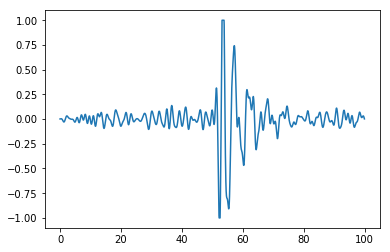

In [202]:
# for i, ant in enumerate(det):
#     fig, ax = plt.subplots(1, 2, figsize=(12, 3))
#     for j, wave in enumerate(ant.all_waveforms):
#         ax[j].plot(wave.times*1e9, wave.values)
#         ax[j].set_xlabel("Time (ns)")
#         ax[j].set_ylabel("Amplitude (V)")
#         ax[j].set_title("First Ray" if j%2==0 else "Second Ray")
#     fig.suptitle("String "+str(int(i/4))+" "+ant.name)
#     plt.show()
plt.plot((ant.all_waveforms[0].times-min(ant.all_waveforms[0].times))*1E9,ant.all_waveforms[0].values)

In [220]:
print(ant.signals.)

[<pyrex.signals.FunctionSignal object at 0x2af187b86400>, <pyrex.signals.FunctionSignal object at 0x2af187b869b0>]
